By expanding a trajectory to second order, the gradient of the covariance matrix (or any function thereof) with respect to nominal design parameters can be computed. This requires expanding in both initial states (and/or parametric uncertainties) and the design parameters. Due to the quadratic nature of the covariance matrix, a second order expansion of the trajectory is required, but this has the additional benefit of enabling Newton-type methods rather than being limited to gradient-based solutions or quasi-Newton approximations. 

Much more care must be taken in a closed loop setting; first the nominal trajectory must be expanded, then any reference variables and gains must be constructed with DA variables. Then, the closed loop trajectory must be expanded in terms of initial conditions and other uncertain terms. 

\begin{align}
\Phi = \frac{\partial}{\partial {x_0}}x_f({x_0}) \\
P_f = \Phi P_0 \Phi^T 
\end{align}

Goals:
- Expand an open loop trajectory and compute the gradient of the covariance matrix 
- Expand a closed loop trajectory 
- A good question to answer is how closely the linear covariance analysis matches the true covariance from a monte carlo 

In [57]:
import sys
sys.path.append("./EntryGuidance")
from scipy.interpolate import interp1d
from scipy.integrate import odeint, cumtrapz 

from pyaudi import gdual_double, gdual_vdouble
import pyaudi as pa 
import numpy as np
# import seaborn
import matplotlib.pyplot as plt 
# from mpl_toolkits.mplot3d import Axes3D
# print(plt.style.available)
# plt.style.use("seaborn-whitegrid")

# from Utils.boxgrid import boxgrid
import Utils.DA as da
from Utils.RK4 import RK4
from Utils.submatrix import submatrix 
from Utils.gpops import srp 

from EntryGuidance.EntryEquations import Entry
from EntryGuidance.Simulation import Simulation, Cycle, EntrySim
from EntryGuidance.InitialState import InitialState
# from ParametrizedPlanner import profile
from EntryGuidance.Apollo import gains 

In [38]:
x0 = InitialState(vehicle='heavy')
print("m0 = {} kg".format(x0[-1]))
Vf = 530 
dasim = Simulation(cycle=Cycle(1), output=True, use_da=True, **EntrySim(Vf=Vf), )

names = ['r', 'theta', 'phi', 'V', 'fpa', 'psi', 's', 'm']
da_names = names + ['u']
order = 2
x0d = da.make(x0, names, order)
u = gdual_double(0.15, 'u', order)
ref_profile = lambda **args: u

res = dasim.run(x0d, [ref_profile])

m0 = 8500.0 kg
Resetting simulation states.

L/D: 0.24
BC : 368.599+0.0433646*dm kg/m^2
current simulation time = 0 s
current simulation time = 10 s
current simulation time = 20 s
current simulation time = 30 s
current simulation time = 40 s
current simulation time = 50 s
current simulation time = 60 s
current simulation time = 70 s
current simulation time = 80 s
current simulation time = 90 s
current simulation time = 100 s
current simulation time = 110 s
current simulation time = 120 s
current simulation time = 130 s
current simulation time = 140 s
current simulation time = 150 s
current simulation time = 160 s
current simulation time = 170 s
current simulation time = 180 s
current simulation time = 190 s
current simulation time = 200 s
current simulation time = 210 s
current simulation time = 220 s
current simulation time = 230 s
current simulation time = 240 s
current simulation time = 250 s
current simulation time = 260 s
current simulation time = 270 s
current simulation time = 2

In [44]:
dasim.history[-1, 3]

3.09956e+06*dfpa**2-1.92774*dV*du+1.29594*dV+0.000143192*dV*dr-7.91754e-08*dm**2+173.244*dV*dfpa-64947.8*dfpa*du+5.1219*dfpa*dr+47976.5*dfpa+0.002201*dV**2+0.0434943*dm-0.0578784*dm*du+4.51755e-06*dm*dr-1676.11*du**2+2.04894e-06*dr**2+525.047+0.000157896*dV*dm-0.0527354*dr*du-620.038*du+5.64105*dfpa*dm+...

In [30]:
print(da.hessian(dasim.history[-1,3], da_names))

[[ 4.09787297e-06  0.00000000e+00  0.00000000e+00  1.43192406e-04
   5.12189746e+00  0.00000000e+00  0.00000000e+00  4.51755163e-06
  -5.27353554e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 1.43192406e-04  0.00000000e+00  0.00000000e+00  4.40199229e-03
   1.73243599e+02  0.00000000e+00  0.00000000e+00  1.57895795e-04
  -1.92773974e+00]
 [ 5.12189746e+00  0.00000000e+00  0.00000000e+00  1.73243599e+02
   6.19911260e+06  0.00000000e+00  0.00000000e+00  5.64104628e+00
  -6.49478020e+04]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.0000000

In [8]:
da_names =['r', 'theta', 'phi', 'V', 'fpa', 'psi', 'u']
stmf = np.array([da.differentiate(x, da_names) for x in dasim.history[-1][0:6]])

In [9]:
P0 = np.diag([100, 0.0001, 0.0001, 1.5, np.radians(0.025), np.radians(0.02), 0])
Pf = stmf.dot(P0).dot(stmf.T)
# W = np.diag(np.ones()
# C = np.trace(Pf)
# dCdu = da.gradient(C, ['u'])
# dCdu
# dPfdu = np.array([da.gradient(x, ['u']) for x in np.diag(Pf)])
dPfdu = np.array([da.jacobian(x, ['u']) for x in Pf[:6]])

print(dPfdu)

array([[-6.00423277e+07, -6.05656839e+02, -1.64336249e+02,
        -2.98050583e+07,  1.92143312e+04,  1.49531862e+04],
       [-6.05656839e+02, -5.42558476e-03, -1.08797681e-03,
        -2.09804316e+02,  1.24348829e-01,  9.93773483e-02],
       [-1.64336249e+02, -1.08797681e-03,  2.26555463e-06,
        -6.63063740e+00, -4.72205476e-03, -1.55299250e-03],
       [-2.98050583e+07, -2.09804316e+02, -6.63063740e+00,
        -2.71920227e+06,  3.03355972e+02,  5.79783951e+02],
       [ 1.92143312e+04,  1.24348829e-01, -4.72205476e-03,
         3.03355972e+02,  9.12975051e-01,  4.47673003e-01],
       [ 1.49531862e+04,  9.93773483e-02, -1.55299250e-03,
         5.79783951e+02,  4.47673003e-01,  1.53644447e-01]])

In [5]:
np.diag(Pf)

array([3.31572e+11*dfpa**2-9877.4*dV*du+717507*dV+16.0713*dV*dr+1.95601e+07*dV*dfpa+0.285436*dm**2-3.34874e+08*dfpa*du+544862*dfpa*dr+2.43255e+10*dfpa+288.474*dV**2+22569.8*dm-310.704*dm*du+0.505536*dm*dr+84565.5*du**2+0.223839*dr**2+4.46155e+08+18.1484*dV*dm-275.144*dr*du-1.22839e+07*du+615280*dfpa*dm+...,
       0.0038449*dfpa*dpsi+1.52619e-11*dr**2+2.15553e-08*dV**2+0.000111546*dpsi-3.43142e-05*dpsi*du-3.4299e-05*dphi*dpsi+4.19015e-05*dV-6.52479e-06*dV*du-1.96953e-07*dm*du+1.26479e-06*dm-1.35973e-08*dphi*dr+1.16626e-07*dV*dpsi+1.14713e-09*dV*dr+2.80037e-05*dphi**2-1.54244e-08*dm*dphi+0.00141521*dV*dfpa+23.229*dfpa**2+3.4626e-11*dm*dr+4.27181e-05*dfpa*dm+3.76574e-05*dfpa*dr+...,
       7.75732e-05*du**2+2.12788e-08*dm*dpsi-0.015447*dphi*dpsi+0.022716*dfpa**2+5.60755e-06*du+0.000144576-8.98019e-09*dphi*dr+0.0238787*dfpa*dpsi-3.64052e-08*dV*du-0.0109675*dfpa*dphi-1.72621e-09*dm*du-1.93322e-07*dV*dphi+1.05805e-12*dV*dm+0.000128967*dphi+3.78158e-14*dm*dr+0.00103891*dphi*du+1.12063e-09*dm

In [6]:
H = np.array([da.hessian(x, ['u']) for x in np.diag(Pf)])

In [7]:
dPfdu/H.squeeze() # Newton step update 

array([-7.26292176e+01, -6.40469477e+00,  3.61436418e-02, -7.04887641e-01,
        5.60933320e-01,  1.46697884e-01])

## Timing, Finite Differencing
A good question to address is how much accuracy we lose for different integration cycles: compare 0.1, 1, 5,?

In [3]:
import time 

def da_integration_timer(order, cycle=1, steps=10):
    x0 = InitialState(vehicle='heavy')
    P0 = np.diag([100, 0.0001, 0.0001, 1.5, np.radians(0.025), np.radians(0.02)])

    Vf = 530 
    dasim = Simulation(cycle=Cycle(cycle), output=False, use_da=True, **EntrySim(Vf=Vf), )

    names = ['r', 'theta', 'phi', 'V', 'fpa', 'psi', 's', 'm']
    da_names = names + ['u']
    x0d = da.make(x0, names, order)
    u = gdual_double(0.15, 'u', order) 
    ref_profile = lambda **args: u

    t0 = time.time()
    dasim.run(x0d, [ref_profile], StepsPerCycle=steps)
    t = time.time() - t0
    print("order {} DA integration: {:.2f} s".format(order, t))

#     stmf = np.array([da.differentiate(x, da_names[0:6]) for x in dasim.history[-1][0:6]])
#     Pf = stmf.dot(P0).dot(stmf.T)
    return t, dasim

In [ ]:
times = []
for i in range(1, 5):
    print(f"Order: {i}")
    t,sim = da_integration_timer(i)
    times.append(t)
times = np.array(times)


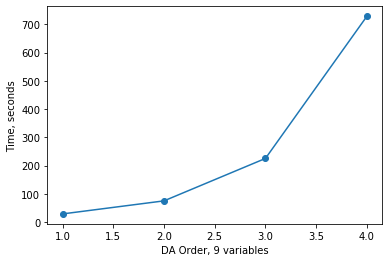

In [63]:

plt.plot(list(range(1,5)), times, 'o-')
plt.xlabel('DA Order, 9 variables')
plt.ylabel('Time, seconds')
plt.savefig('DA_time_vs_order.png')
# plt.show()

In [41]:
times = []
xf = []
# dts = [1, 5]
dts = [0.1, 0.5, 1, 5, 10]
for dt in dts:
    print(f"dt: {dt}")
    t,sim = da_integration_timer(order=2, cycle=dt, steps=2)
    xf.append(sim.history)
    times.append(t)
times = np.array(times)
# xf = np.array(xf)

dt: 0.1
order 2 DA integration: 110.18 s
dt: 0.5
order 2 DA integration: 21.98 s
dt: 1
order 2 DA integration: 11.04 s
dt: 5
order 2 DA integration: 2.24 s
dt: 10
order 2 DA integration: 1.13 s


Text(0.5, 0, 'Step size (s)')

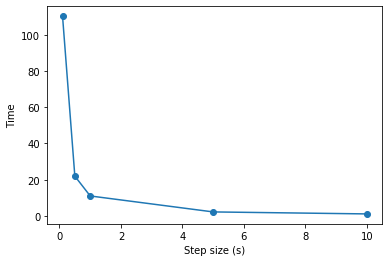

In [42]:
plt.plot(dts, times, 'o-')
plt.ylabel('Time')
plt.xlabel('Step size (s)')

In [43]:
# print(da.const(xf[:,3]))
names = ['r', 'theta', 'phi', 'V', 'fpa', 'psi', 'u']
for xfi in xf[1:]:
#     print(da.const(xfi[:,3], True)[-1])
    # interpolate the coarser integrations onto the same final velocity 
    
    xfv = da.interp([xf[0][-1,3].constant_cf], da.const(xfi[::-1,3], True), xfi[::-1])[0]
#     for state in xfv:
#         display(state.constant_cf)
#     for state in xf[0][-1]:
#         display(state.constant_cf)
            
        
    delta = xfv-xf[0][-1]
    h,lon,lat,v,fpa,psi,s,m = delta
    for d,state,unit in zip(delta, ['radius','lon','lat'], ['m','rad','rad']):
        print(f"Error in Constant Term of final {state}: {d.constant_cf} {unit}")
    for d,state,unit in zip(delta[4:], ['fpa','heading'], ['deg']*2):
        print(f"Error in Constant Term of final {state}: {np.degrees(d.constant_cf)} {unit}")

        
#     display(da.jacobian(delta, names))
    pdiff = da.jacobian(delta, names)/da.jacobian(xf[0][-1], names) * 100 
    pdiff[np.isnan(pdiff)] = 0
    pdiff_max = np.max(np.abs(pdiff))
    print("Maximum % error over the terminal jacobian = {:.3f}%".format(pdiff_max))
#     display() # Percent diff, lots of nans anywhere with zero gradient 

#     for d in delta:
#         display(da.gradient(delta[0], names))
#         display(da.gradient(delta[0], names)/da.gradient(xf[0][-1]))

    print("\n")

print("Somewhat surprisingly, large steps can be take with minimal loss, at least for a constant bank angle")

Error in Constant Term of final radius: -0.04128614207729697 m
Error in Constant Term of final lon: -1.4585660457200333e-10 rad
Error in Constant Term of final lat: -2.9286213332896383e-09 rad
Error in Constant Term of final fpa: -0.0001773126082769952 deg
Error in Constant Term of final heading: -1.637340795302116e-05 deg
Maximum % error over the terminal jacobian = 0.002%


Error in Constant Term of final radius: -0.1105618136934936 m
Error in Constant Term of final lon: -2.3513928582019616e-09 rad
Error in Constant Term of final lat: -7.715533874991243e-09 rad
Error in Constant Term of final fpa: -0.00047432987801853283 deg
Error in Constant Term of final heading: -4.371230690341263e-05 deg
Maximum % error over the terminal jacobian = 0.005%


Error in Constant Term of final radius: -3.9427922600880265 m
Error in Constant Term of final lon: -1.4786077787154461e-06 rad
Error in Constant Term of final lat: -2.0982508194475336e-07 rad
Error in Constant Term of final fpa: -0.01692246677

E:\Anaconda3\envs\research\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


In [50]:
print(dasim.history[-1])

[3.39522e+06-13510.2*du -0.0693269*du+0.429422 -0.0639088*du-0.00978863
 525.047-620.038*du -0.229688-0.32523*du -0.745133*du-0.102627
 -228978*du+2.37889e+06 8500]


In [24]:
gradient = []
for unew in [0.149, 0.151,]:
    ref_profile = lambda **args: unew
    t0 = time.time()
    res = dasim.run(x0d, [ref_profile])
    print("\nFirst order DA integration: {:.2f} s".format(time.time()-t0))
    stmf = np.array([da.differentiate(x, da_names[0:6]) for x in dasim.history[-1][0:6]])
    Pf_new = stmf.dot(P0).dot(stmf.T)

    dPf_du = ( Pf_new - Pf ) / (unew-u)
    gradient.append(dPf_du)
    print(dPf_du)
    
dPf_du_central = np.mean(gradient, axis=0)
print("\nCentral difference:")
print(dPf_du_central)


Central difference:
[[-6.00414e+07 -605.655 -164.337 -2.98049e+07 19214.4 14953.2]
 [-605.655 -0.00542561 -0.00108798 -209.804 0.124349 0.0993773]
 [-164.337 -0.00108798 2.26584e-06 -6.63062 -0.00472211 -0.00155301]
 [-2.98049e+07 -209.804 -6.63062 -2.71918e+06 303.351 579.782]
 [19214.4 0.124349 -0.00472211 303.351 0.912982 0.447676]
 [14953.2 0.0993773 -0.00155301 579.782 0.447676 0.153645]]


In [12]:
print("Using differential algebra, dPf/du = ")
print(dPfdu)

Using differential algebra, dPf/du = 
[[-6.00423277e+07 -6.05656839e+02 -1.64336249e+02 -2.98050583e+07
   1.92143312e+04  1.49531862e+04]
 [-6.05656839e+02 -5.42558476e-03 -1.08797681e-03 -2.09804316e+02
   1.24348829e-01  9.93773483e-02]
 [-1.64336249e+02 -1.08797681e-03  2.26555463e-06 -6.63063740e+00
  -4.72205476e-03 -1.55299250e-03]
 [-2.98050583e+07 -2.09804316e+02 -6.63063740e+00 -2.71920227e+06
   3.03355972e+02  5.79783951e+02]
 [ 1.92143312e+04  1.24348829e-01 -4.72205476e-03  3.03355972e+02
   9.12975051e-01  4.47673003e-01]
 [ 1.49531862e+04  9.93773483e-02 -1.55299250e-03  5.79783951e+02
   4.47673003e-01  1.53644447e-01]]


In [25]:
np.abs(dPfdu-da.const(dPf_du_central))/dPfdu * 100 

array([[-1.61789547e-03, -2.51784184e-04, -3.22957267e-04,
        -3.91395948e-04,  1.36092009e-04,  8.38860768e-05],
       [-2.51784184e-04, -4.00525751e-04, -2.34335869e-04,
        -3.27111019e-04,  4.18164361e-05,  2.01169914e-06],
       [-3.22957267e-04, -2.34335870e-04,  1.25666668e-02,
        -3.13368293e-04, -1.13042521e-03, -9.37532641e-04],
       [-3.91395948e-04, -3.27111033e-04, -3.13368292e-04,
        -6.98790388e-04,  1.76064514e-03,  3.58027993e-04],
       [ 1.36092004e-04,  4.18164416e-05, -1.13042521e-03,
         1.76064516e-03,  8.05666254e-04,  6.52190259e-04],
       [ 8.38860753e-05,  2.01169826e-06, -9.37532643e-04,
         3.58027994e-04,  6.52190259e-04,  2.03767466e-04]])

That weird saturation used in desensitizing the minimum fuel powered descent paper

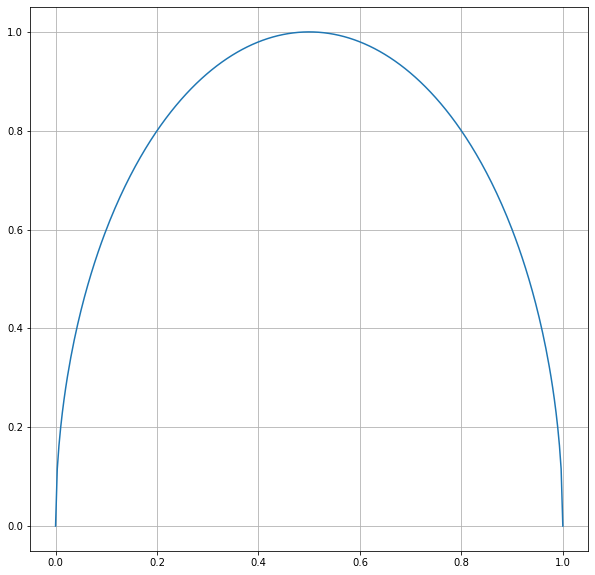

In [40]:
umin = 0
umax = 1

u = np.linspace(0,1,300)

def sat(u, umin, umax):
    return 4*(u-umin)*(umax-u)/(umax-umin)**2

plt.figure(figsize=(10,10))
plt.plot(u, sat(u, umin, umax)**0.5)
plt.grid(True)
plt.show()

In [8]:
[display(x) for x in dasim.history[2:4, 0]]

-0.494398*dV-2.22188e-08*dm+11627.6*dfpa+3.53701e+06+0.999998*dr

-0.736817*dV-5.27794e-08*dm+17448.7*dfpa+3.53552e+06+0.999997*dr

[None, None]

In [96]:
da.interp([0.5],np.array([0,1]),dasim.history[2:4, 0])[0]

3.53626e+06-2.32903e-05*du

In [16]:
np.mean(dasim.history[2:4, 0])

-0.615607*dV-3.74991e-08*dm+14538.2*dfpa+3.53626e+06+0.999997*dr

In [43]:
dasim.history[100, 3].extract_terms(2).subs('dm', 0).subs('du', 0)

-478999*dfpa**2-1.56486e-06*dr**2-0.000179553*dV**2+3.89323e-05*dV*dr-1.72145*dfpa*dr+25.3655*dV*dfpa

m0 = 8500.0 kg
Resetting simulation states.

L/D: 0.24
BC : 368.598738682043 kg/m^2
current simulation time = 0 s
current simulation time = 10 s
current simulation time = 20 s
current simulation time = 30 s
current simulation time = 40 s
current simulation time = 50 s
current simulation time = 60 s
current simulation time = 70 s
current simulation time = 80 s
current simulation time = 90 s
current simulation time = 100 s
current simulation time = 110 s
current simulation time = 120 s
current simulation time = 130 s
current simulation time = 140 s
current simulation time = 150 s
current simulation time = 160 s
current simulation time = 170 s
current simulation time = 180 s
current simulation time = 190 s
current simulation time = 200 s
current simulation time = 210 s
current simulation time = 220 s
current simulation time = 230 s
current simulation time = 240 s
current simulation time = 250 s
Transitioning from state Entry to Complete because the following condition was met:
Altitude <=

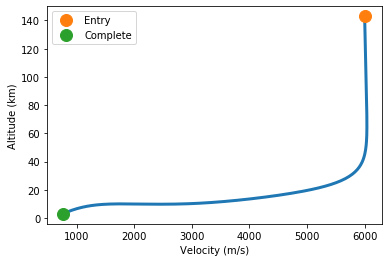

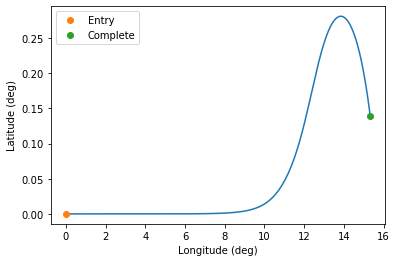

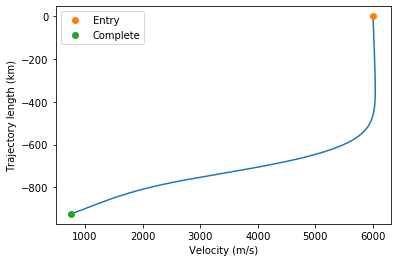

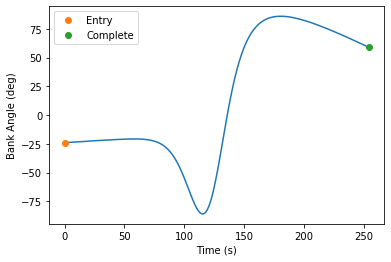

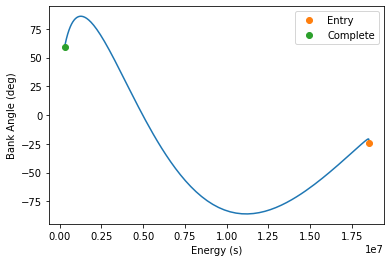

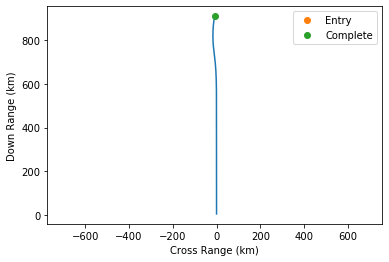

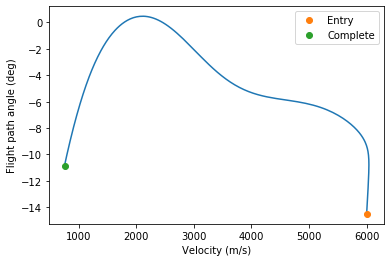

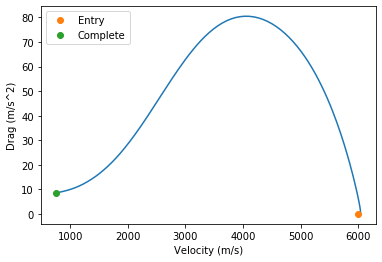

In [58]:
from Triggers import AltitudeTrigger
x0 = InitialState(vehicle='heavy')
print("m0 = {} kg".format(x0[-1]))
Vf = 330 

sim_conditions = EntrySim(Vf=Vf)
sim_conditions['conditions'] = [AltitudeTrigger(3)]

sim = Simulation(cycle=Cycle(1), output=True, **sim_conditions, )

ref_profile = lambda **args: np.sin(args['velocity']/1000.)*1.5

# v = np.linspace(5000, Vf, 1000)
# plt.plot(v, np.degrees(np.sin(v/500.)))
# plt.show()

res = sim.run(x0, [ref_profile])
sim.plot()

In [59]:
# target = (h, lon, lat)
target = [0e3, np.radians(15.4), 0.0]
def spherical_to_cartesian(x, target):
    r,th,ph,v,fpa,azi,s,m = x
    x,y = sim.edlModel.planet.range(th,ph,azi, target[1], target[2], km=False)
    z = sim.edlModel.altitude(r, km=False) - target[0] 
    vx = v*np.cos(fpa)*np.cos(azi) 
    vy = v*np.cos(fpa)*np.sin(azi)
    vz = v*np.sin(fpa)
    return [x, y, z, vx, vy, vz]

In [60]:
def solve_srp(x_cart, m0, display=False):
    x_cart.append(m0)
    x_cart = [float(x) for x in x_cart]
    srp_sol = srp((x_cart, 0)) # srp takes cartesian states, with the target at the origin 
    srp_x = np.array(srp_sol['state'])
    srp_u = np.array(srp_sol['control'])
    srp_t = np.array(srp_sol['time']).squeeze()
    if display:
        print("Optimal ToF = {:.1f} s".format(srp_t[-1]))
        print("Optimal Prop = {:.1f} kg".format(srp_x[0,-1]-srp_x[-1,-1]))
    return srp_t, srp_x, srp_u

In [61]:
print(sim.history.shape)
mprop = []
sol = []
for x in sim.history[240:-1:2]:
    x_cart = spherical_to_cartesian(x, target)
    print(x_cart)
    t,x,u = solve_srp(x_cart, 8500, display=True)
    sol.append((t,x,u))
    mprop.append(x[-1,-1]) 


(255, 8)
[17406.05106322574, 7524.15838050389, 4794.664208166767, 845.9025483899766, -153.2269714106775, -130.80575186438452]
No shared Matlab instance found, creating a new instance...
Matlab instance created successfully.
Optimal ToF = 32.1 s
Optimal Prop = 5636.4 s
[15750.909620771628, 7425.976596966812, 4531.120231649838, 827.7300778539958, -155.0061102312109, -132.72254676640884]
No shared Matlab instance found, creating a new instance...
Matlab instance created successfully.
Optimal ToF = 34.7 s
Optimal Prop = 5211.5 s
[14130.192149365475, 7336.938171303556, 4263.856624688022, 809.7752429488609, -156.64705668886782, -134.52550196984186]
No shared Matlab instance found, creating a new instance...
Matlab instance created successfully.
Optimal ToF = 34.7 s
Optimal Prop = 5207.4 s
[12543.510881601911, 7256.976804329072, 3993.10000132164, 792.0336579914417, -158.14971790164012, -136.21569586348735]
No shared Matlab instance found, creating a new instance...
Matlab instance created suc

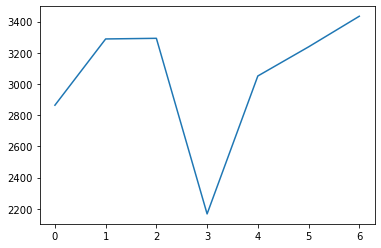

In [62]:
plt.plot(mprop)

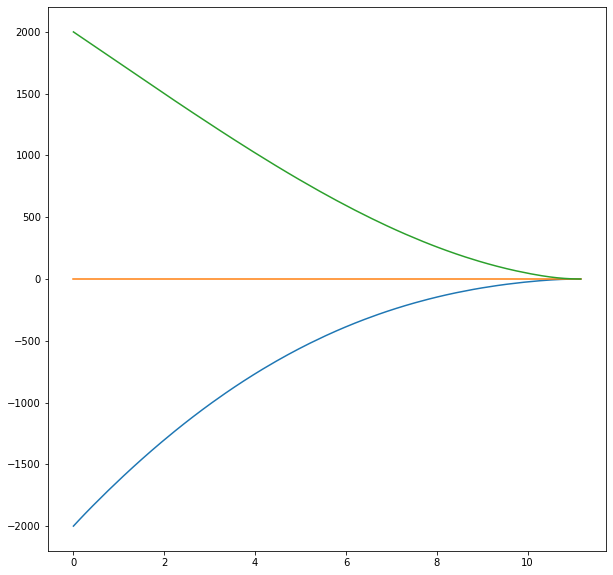

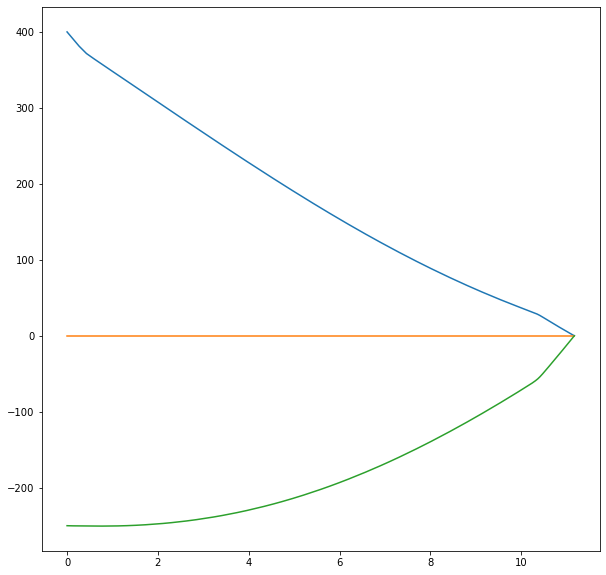

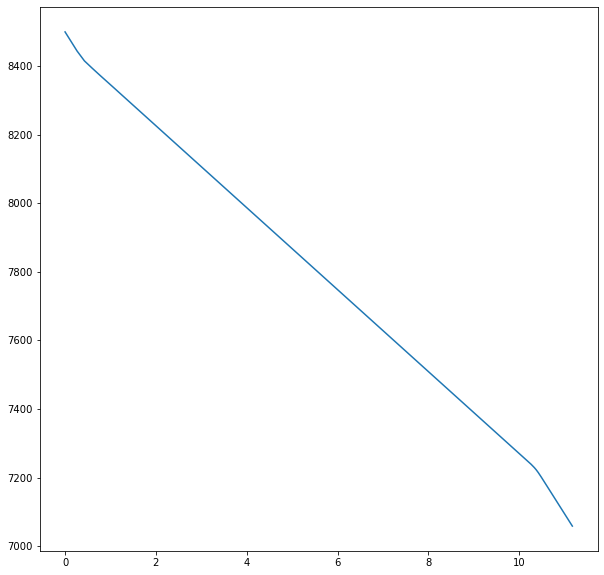

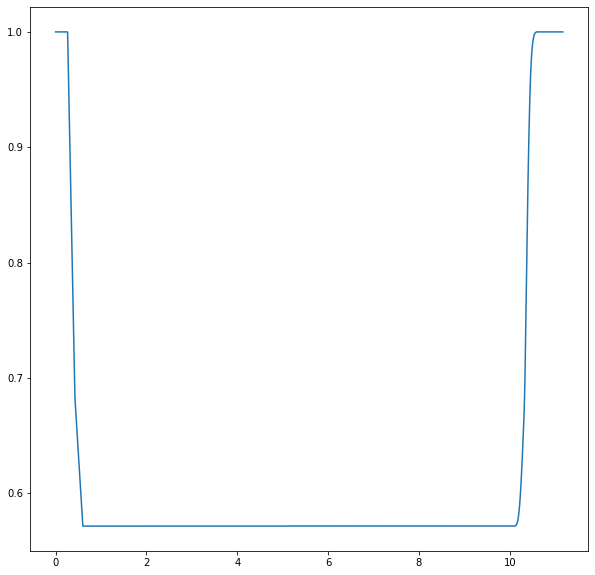

In [54]:
def srp_plot(srp_t, srp_x, srp_u):

    figsize = (10,10)
    plt.figure(figsize=figsize)
    plt.plot(srp_t, srp_x[:,:3])
    plt.xlabel('Time since ignition (s)')
    plt.figure(figsize=figsize)
    plt.plot(srp_t, srp_x[:,3:6])
    plt.xlabel('Time since ignition (s)')
    plt.figure(figsize=figsize)
    plt.plot(srp_t, srp_x[:,-1])
    plt.xlabel('Time since ignition (s)')

    plt.figure(figsize=figsize)
    plt.plot(srp_t, srp_u[:,0]/(70*8500))
    plt.xlabel('Time since ignition (s)')

# Multi-phase adjoint/STM computations

\begin{align}
J(x_f) = m_f \\ 
\frac{\partial J}\frac{\partial p} = \frac{\partial J}\frac{\partial x}
\end{align}
